# Eye Track, Initial Exploration

In [1]:
import json
import re
import ast
import pandas as pd
from datetime import datetime
import time
import hypertools as hyp
import numpy as np
from matplotlib import pyplot as plt
import os
from matplotlib import patches as patches
import seaborn as sb
from analysis_helpers import *
import warnings
warnings.filterwarnings('ignore')
import scipy

# Parse json file 

In [2]:
params = {'runs':8, 'presentations_per_run':10, 
          'invalid_cue_percentage':10, 'mem_to_pres':4, 
          'mem_pres_split':2}

dr = '/Users/student/Desktop/attention-memory-task/data/'

In [3]:
def df_create(data):
    """
    input: raw parsed eye data
    output: dataframe of eye data (screen location in centimeters)
    """

    dict_list = [ast.literal_eval(x) for x in data]
    dict_list = [x['values']['frame'] for x in dict_list if 'frame' in x['values']]

    df = pd.DataFrame(dict_list)

    # right and left eye
    for eye in ['righteye','lefteye']:
        for coord in ['x','y']:
            df[coord+'Raw_'+eye] = [df[eye][row]['raw'][coord] for row in df.index.values]

    # convert to centimeters
    df['av_x_coord'] = (59.8/2048)*(df[['xRaw_righteye', 'xRaw_lefteye']].mean(axis=1))
    df['av_y_coord'] = (33.6/1152)*(df[['yRaw_righteye', 'yRaw_lefteye']].mean(axis=1))

    # convert timestamp
    df['timestamp']=[time.mktime(time.strptime(x[:], "%Y-%m-%d %H:%M:%S.%f")) for x in df['timestamp']]

    return(df)

# Subject Overview

In [4]:
def ROC(df, plot=True):
    '''
    input: subject df
    output: ROC plot or ROC data dict
    '''
    ratings = [1.0, 2.0, 3.0, 4.0]
    ROC = {}

    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    # for each attention level
    for attn in ['Novel', 'None','Side','Full','Category']:

        ROC[attn] = [0, 1]

        # for each possible number rating
        for rate in ratings:

            # proportion of images in that attn level rated this rating or higher
            num = df.loc[(df['Attention Level'] == attn) & (df['Familiarity Rating'] >= rate)].shape[0]
            denom = df.loc[df['Attention Level'] == attn].shape[0]
            ROC[attn].append(float(num)/denom)

        ROC[attn].sort()

        # proportions of various attention-level images, by rating, on y-axis
        # proportions of novel images, by rating, on x-axis
        if attn != 'Novel':
            ax1.plot(ROC['Novel'], ROC[attn], '-o', label=attn)
    return(fig)


def gaze_plot(df_list):

    middle = 2048/2.0
    quarter = (1304-744)/4.0

    fig = plt.figure()
    ax1 = fig.add_subplot(111, aspect='equal')

    for x in df_list:
        if x['Cued Side'].all()=='>' and x['Cued Category'].all()=='Place':
            color='green'
        elif x['Cued Side'].all()=='>' and x['Cued Category'].all()=='Face':
            color='blue'
        elif x['Cued Side'].all()=='<' and x['Cued Category'].all()=='Place':
            color='orange'
        else:
            color='red'

        x['Color']=color

        ax1.plot(x['av_x_coord'], x['av_y_coord'], '.', color=color)
        #props.append(x.loc[(x['av_x_coord']>middle-quarter) & (x['av_x_coord']<middle+quarter)])

    rect1 = patches.Rectangle(((59.8/2.0)-8-3.5,(33.6/2)-3.5),7,7,linewidth=1,edgecolor='black',facecolor='none')
    rect2 = patches.Rectangle(((59.8/2.0)+8-3.5,(33.6/2)-3.5),7,7,linewidth=1,edgecolor='black',facecolor='none')

    # Add the patch to the Axes
    ax1.add_patch(rect1)
    ax1.add_patch(rect2)
    
    plt.ylim(0, 33.6)
    plt.xlim(0, 59.8)
    
    return(fig)

()
0_2018_Sep_25
()
10_2018_Oct_03
()
11_2018_Oct_03
()
2_2018_Sep_26
()
6_2018_Sep_28
()
7_2018_Oct_03
()
8_2018_Oct_03
()
9_2018_Oct_03


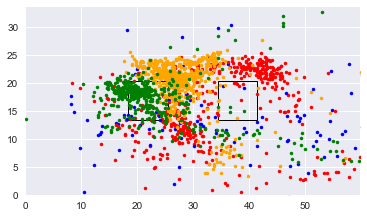

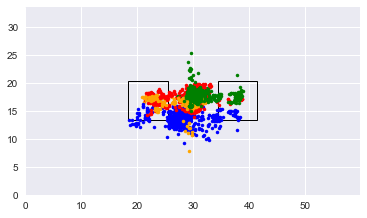

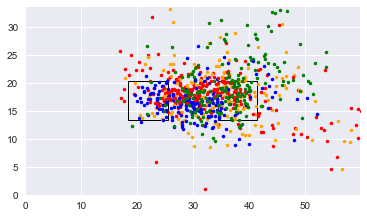

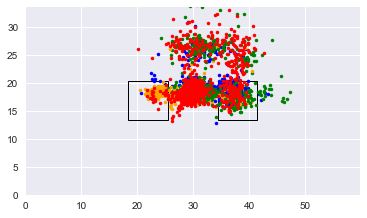

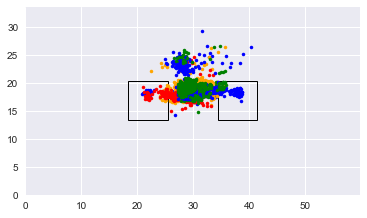

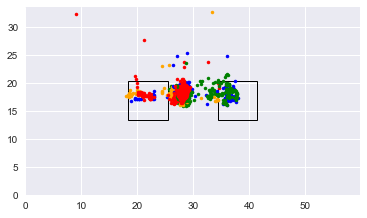

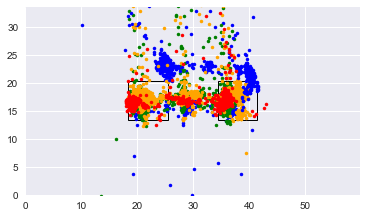

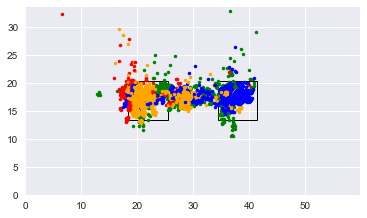

In [33]:
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages

#
# with PdfPages('foo.pdf') as pdf:
#     for i, group in df.groupby('station_id'):
#         plt.figure()
#         fig=group.plot(x='year', y='Value',title=str(i)).get_figure()
#

data_dir = '/Users/Student/Desktop/attention-memory-task/data/'
#df_lists=[]


for sub in os.listdir(data_dir):

    print()
    print(sub)

    # Behavioral
#     df = add_level(sum_pd(data_dir+sub))
#     df = pd.concat([df])
#     sb_plot = sb.boxplot(x='Cue Validity',y='Attention Reaction Time (s)', hue='Cue Validity',data=df[df['Trial Type']=='Presentation'])
#     fig = sb_plot.get_figure()
#     fig.savefig("bar"+sub+".png")
#     roc=ROC(df)
#     roc.savefig("roc"+sub+".pdf", bbox_inches='tight')

    # Eye Gaze
    loaded = load(data_dir+sub+'/'+'eye_data/')
    df = df_create(loaded)
    df_list = pres_gaze(data_dir+sub, df, interval='images')
    gp=gaze_plot(df_list)
    gp.savefig("gp"+sub+".pdf", bbox_inches='tight')
    #df_lists.append(df_list)

In [28]:
# for x in df_lists:
#     sb.boxplot(gaze_props(x))
#     plt.show()
#     print(len(x))

len(df_lists)

8

In [39]:
import scipy

for subject in df_lists:
    rl_dict = {'right':[],'left':[]}
    dct={'>_Face':rl_dict,'>_Place':rl_dict,'<_Face':rl_dict,'<_Place':rl_dict}
    
    for trial in subject:
        # right = number gazepoints right half of screen
        # left = number of gazepoints left half of screen
        side = trial.iloc[0]['Cued Side']
        cat = trial.iloc[0]['Cued Category']
        dct[side+'_'+cat]['right'].append(trial.loc[trial['av_x_coord'] > 59.8/2].shape[0])
        dct[side+'_'+cat]['left'].append(trial.loc[trial['av_x_coord'] < 59.8/2].shape[0])
        
    x = dct['>_Face']['right']+dct['>_Place']['right']
    y = dct['<_Face']['right']+dct['<_Place']['right']
    scipy.stats.ttest_ind(x, y) #, axis=0, equal_var=True, nan_policy='propagate')
        

IndexError: single positional indexer is out-of-bounds

In [30]:
trial

,avg,fix,lefteye,raw,righteye,state,time,timestamp,xRaw_righteye,yRaw_righteye,xRaw_lefteye,yRaw_lefteye,av_x_coord,av_y_coord,Cued Side,Cued Category,Color
10661,"{u'y': 456.3401, u'x': 976.3664}",False,"{u'raw': {u'y': 303.2968, u'x': 926.6053}, u'a...","{u'y': 440.9055, u'x': 945.6897}","{u'raw': {u'y': 578.5143, u'x': 964.774}, u'av...",7,294090187,1.537892e+09,964.7740,578.5143,926.6053,303.2968,27.613399,12.859745,>,Face,blue
10666,"{u'y': 329.2178, u'x': 1678.3964}",False,"{u'raw': {u'y': 260.0191, u'x': 1946.302}, u'a...","{u'y': 443.7292, u'x': 1420.0801}","{u'raw': {u'y': 627.4394, u'x': 893.8582}, u'a...",7,294090375,1.537892e+09,893.8582,627.4394,1946.3020,260.0191,41.465229,12.942103,>,Face,blue
10672,"{u'y': 395.8426, u'x': 1556.0288}",False,"{u'raw': {u'y': 179.3951, u'x': 2678.635}, u'a...","{u'y': 365.6873, u'x': 1801.5481}","{u'raw': {u'y': 551.9796, u'x': 924.4613}, u'a...",7,294090596,1.537892e+09,924.4613,551.9796,2678.6350,179.3951,52.603799,10.665881,>,Face,blue
10674,"{u'y': 450.2529, u'x': 1399.5864}",False,"{u'raw': {u'y': 381.4583, u'x': 3427.1968}, u'...","{u'y': 474.1432, u'x': 2150.4241}","{u'raw': {u'y': 566.8281, u'x': 873.6516}, u'a...",7,294090663,1.537892e+09,873.6516,566.8281,3427.1968,381.4583,62.790707,13.829177,>,Face,blue
10686,"{u'y': 132.9011, u'x': 1372.3855}",False,"{u'raw': {u'y': 356.9409, u'x': 94874.2266}, u...","{u'y': 244.921, u'x': 48123.3047}","{u'raw': {u'y': 132.9011, u'x': 1372.3855}, u'...",7,294091106,1.537892e+09,1372.3855,132.9011,94874.2266,356.9409,1405.162940,7.143529,>,Face,blue
10693,"{u'y': 342.8864, u'x': 2407.5276}",False,"{u'raw': {u'y': 454.1954, u'x': 2997.7937}, u'...","{u'y': 293.148, u'x': 2216.0452}","{u'raw': {u'y': 132.1005, u'x': 1434.2968}, u'...",7,294091369,1.537892e+09,1434.2968,132.1005,2997.7937,454.1954,64.706790,8.550149,>,Face,blue
10699,"{u'y': 608.3195, u'x': 4143.3242}",False,"{u'raw': {u'y': 832.9644, u'x': 11558.9238}, u...","{u'y': 471.5011, u'x': 6495.0195}","{u'raw': {u'y': 110.0377, u'x': 1431.1155}, u'...",7,294091588,1.537892e+09,1431.1155,110.0377,11558.9238,832.9644,189.649500,13.752114,>,Face,blue
10701,"{u'y': 584.8712, u'x': 4422.8608}",False,"{u'raw': {u'y': 821.7189, u'x': 10157.8838}, u...","{u'y': 699.8698, u'x': 5589.1489}","{u'raw': {u'y': 578.0207, u'x': 1020.4144}, u'...",7,294091666,1.537892e+09,1020.4144,578.0207,10157.8838,821.7189,163.198787,20.412869,>,Face,blue
10702,"{u'y': 597.9613, u'x': 2661.7275}",False,"{u'raw': {u'y': 16.5917, u'x': 3693.8855}, u'a...","{u'y': 320.2366, u'x': 2318.343}","{u'raw': {u'y': 623.8815, u'x': 942.8004}, u'a...",7,294091700,1.537892e+09,942.8004,623.8815,3693.8855,16.5917,67.693803,9.340234,>,Face,blue
10704,"{u'y': 485.8832, u'x': 1044.3171}",False,"{u'raw': {u'y': 772.2974, u'x': 13095.2471}, u...","{u'y': 430.0366, u'x': 7271.4946}","{u'raw': {u'y': 87.7757, u'x': 1447.7423}, u'a...",7,294091776,1.537892e+09,1447.7423,87.7757,13095.2471,772.2974,212.321964,12.542733,>,Face,blue


In [ ]:
av_x_coord